# Benchmark aggregation by hardware

This notebook loads a benchmark CSV (same format as the project outputs) and builds
per-hardware dataframes that include IDLE rows and the mean across repeats for each run.


In [8]:
from pathlib import Path
import pandas as pd

# Update this path if needed
csv_path = Path("pi_oak_benchmark_results.csv")
if not csv_path.exists():
    csv_path = Path("..") / csv_path

csv_path

PosixPath('../pi_oak_benchmark_results.csv')

In [9]:
df = pd.read_csv(csv_path)
df.head()

,Timestamp,Phase,Hardware,Model_Name,Size_MB,ImgSz,E2E_Time_ms,Device_Time_ms,mAP50,Precision,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,2026-01-15T16:11:03.209312,idle,CPU_ORT_PI4_SEQ_ALL,IDLE,0.00,0,0.00,0.00,0.0000,0.0000,...,0.5,300,10,8.3.241,2.28.0.0,4.9.0,2.9.1+cpu,NaN,NaN,1.23.2
1,2026-01-15T16:12:21.084310,run,CPU_ORT_PI4_SEQ_ALL,yolo11n_640_fp32,10.21,640,545.11,499.51,0.6716,0.7371,...,0.5,300,10,8.3.241,2.28.0.0,4.9.0,2.9.1+cpu,NaN,NaN,1.23.2
2,2026-01-15T16:13:37.912364,run,CPU_ORT_PI4_SEQ_ALL,yolo11n_640_fp32,10.21,640,544.48,500.79,0.6716,0.7371,...,0.5,300,10,8.3.241,2.28.0.0,4.9.0,2.9.1+cpu,NaN,NaN,1.23.2
3,2026-01-15T16:14:55.664674,run,CPU_ORT_PI4_SEQ_ALL,yolo11n_640_fp32,10.21,640,552.13,506.11,0.6716,0.7371,...,0.5,300,10,8.3.241,2.28.0.0,4.9.0,2.9.1+cpu,NaN,NaN,1.23.2
4,2026-01-15T16:16:15.569016,run,CPU_ORT_PI4_SEQ_BASIC,yolo11n_640_fp32,10.21,640,566.88,521.55,0.6716,0.7371,...,0.5,300,10,8.3.241,2.28.0.0,4.9.0,2.9.1+cpu,NaN,NaN,1.23.2


In [10]:
def aggregate_by_hardware(df_in: pd.DataFrame, hardware_prefix: str) -> pd.DataFrame:
    hw_df = df_in[df_in["Hardware"].str.startswith(hardware_prefix, na=False)].copy()
    if hw_df.empty:
        return pd.DataFrame()

    # Convert numeric columns
    for col in hw_df.columns:
        if col in {"Timestamp", "Phase", "Hardware", "Model_Name", "Dataset", "Backend",
                   "ORT_Level_Requested", "Providers_Used"}:
            continue
        hw_df[col] = pd.to_numeric(hw_df[col], errors="coerce")

    id_cols = [c for c in hw_df.columns if c != "Timestamp" and not pd.api.types.is_numeric_dtype(hw_df[c])]
    num_cols = [c for c in hw_df.columns if c not in id_cols + ["Timestamp"]]

    agg = (
        hw_df
        .groupby(id_cols, dropna=False)[num_cols]
        .mean(numeric_only=True)
        .reset_index()
    )

    # Keep idle first, then run rows ordered by model name
    if "Phase" in agg.columns and "Model_Name" in agg.columns:
        agg = agg.sort_values(["Phase", "Model_Name"], ascending=[True, True])

    return agg


df_gpu = aggregate_by_hardware(df, "GPU_")
df_cpu_pc = aggregate_by_hardware(df, "CPU_ORT_PC")
df_cpu_pi = aggregate_by_hardware(df, "CPU_ORT_PI4")
df_oak = aggregate_by_hardware(df, "OAK_")


dfs = {
    "gpu": df_gpu,
    "cpu_pc": df_cpu_pc,
    "cpu_pi": df_cpu_pi,
    "oak": df_oak,
}

for name, d in dfs.items():
    if d is None or d.empty:
        continue
    print(f"{name}: {len(d)} rows")
    display(d.head())


cpu_pi: 31 rows


,Phase,Hardware,Model_Name,ORT_Level_Requested,Providers_Used,Dataset,Backend,Size_MB,ImgSz,E2E_Time_ms,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,idle,CPU_ORT_PI4_SEQ_ALL,IDLE,all->all,CPUExecutionProvider,coco128,onnxruntime-cpu,0.00,0.0,0.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,run,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp16,"ALL_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,5.07,256.0,105.676667,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,run,CPU_ORT_PI4_SEQ_BASIC,yolo11n_256_fp16,"BASIC_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,5.07,256.0,122.890000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,run,CPU_ORT_PI4_SEQ_DISABLE,yolo11n_256_fp16,"DISABLE_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,5.07,256.0,122.850000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,run,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp32,"ALL_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,10.07,256.0,101.733333,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


oak: 76 rows


,Phase,Hardware,Model_Name,ORT_Level_Requested,Providers_Used,Dataset,Backend,Size_MB,ImgSz,E2E_Time_ms,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,idle,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_4,IDLE,NaN,NaN,coco128,depthai,0.00,0.0,0.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_4,yolo11m_256_fp16_4shave,NaN,NaN,coco128,depthai,39.75,256.0,144.530000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_5,yolo11m_256_fp16_5shave,NaN,NaN,coco128,depthai,39.74,256.0,148.780000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11m_256_fp16_6shave,NaN,NaN,coco128,depthai,39.74,256.0,143.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11m_256_fp16_7shave,NaN,NaN,coco128,depthai,39.74,256.0,142.803333,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Quick sanity checks
print("GPU rows:", len(df_gpu))
print("CPU rows:", len(df_cpu_pc))

print("GPU idle rows:", (df_gpu["Phase"] == "idle").sum() if not df_gpu.empty else 0)
print("CPU idle rows:", (df_cpu_pc["Phase"] == "idle").sum() if not df_cpu_pc.empty else 0)

GPU rows: 0
CPU rows: 0
GPU idle rows: 0
CPU idle rows: 0


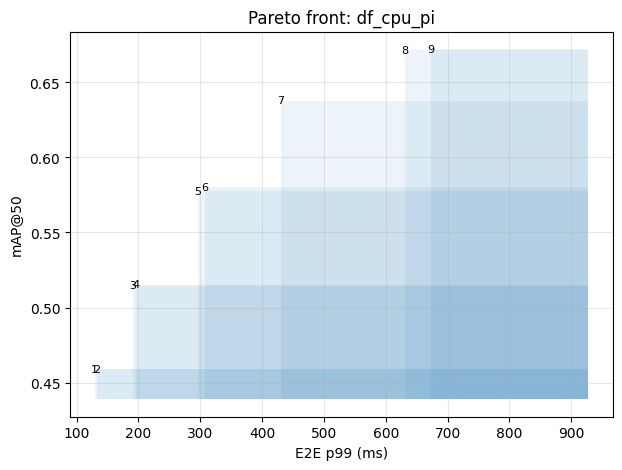

,Pareto_id,Label
0,1,n 256 fp32 ORT ALL
1,2,n 256 fp16 ORT ALL
2,3,n 320 fp32 ORT ALL
3,4,n 320 fp16 ORT ALL
4,5,n 416 fp32 ORT ALL
5,6,n 416 fp16 ORT ALL
6,7,n 512 fp32 ORT ALL
7,8,n 640 fp32 ORT ALL
8,9,n 640 fp16 ORT ALL


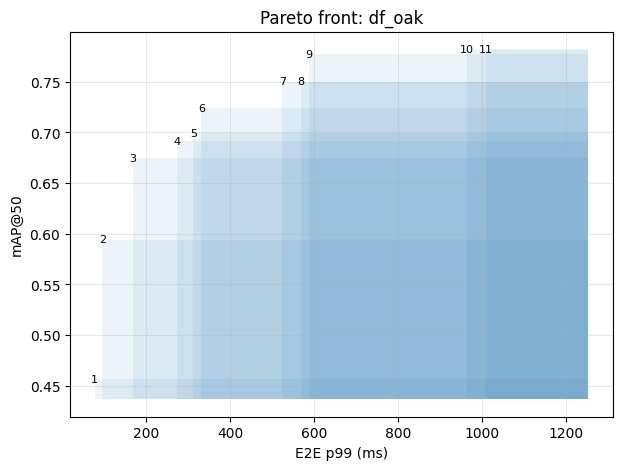

,Pareto_id,Label
0,1,n 256 fp16 OAK S6
1,2,s 256 fp16 OAK S4
2,3,m 256 fp16 OAK S4
3,4,s 416 fp16 OAK S7
4,5,m 320 fp16 OAK S7
5,6,s 512 fp16 OAK S7
6,7,m 416 fp16 OAK S8
7,8,m 416 fp16 OAK S5
8,9,m 512 fp16 OAK S8
9,10,m 640 fp16 OAK S8


In [12]:
import re
import numpy as np
import matplotlib.pyplot as plt

def pareto_min_max(df: pd.DataFrame, min_col: str, max_col: str) -> pd.DataFrame:
    work = df.copy()
    work = work[(work["Phase"] == "run") & work[min_col].notna() & work[max_col].notna()]
    if work.empty:
        return work

    vals = work[[min_col, max_col]].values
    is_pareto = np.ones(len(work), dtype=bool)

    for i, (x, y) in enumerate(vals):
        if not is_pareto[i]:
            continue
        dominated = (vals[:, 0] <= x) & (vals[:, 1] >= y) & (
            (vals[:, 0] < x) | (vals[:, 1] > y)
        )
        if dominated.any():
            is_pareto[i] = False

    return work[is_pareto].sort_values([min_col, max_col], ascending=[True, False])


def short_label(row: pd.Series) -> str:
    name = str(row.get("Model_Name", ""))
    match = re.search(r"yolo11([nsm])_(\d+)_(fp16|fp32|int8)", name)
    if match:
        scale, imgsz, quant = match.groups()
        base = f"{scale} {imgsz} {quant}"
    else:
        base = name

    hardware = str(row.get("Hardware", ""))
    backend = ""
    opt = ""

    if "ORT" in hardware:
        backend = "ORT"
        m2 = re.search(r"_(ALL|BASIC|DISABLE)\b", hardware)
        if m2:
            opt = m2.group(1)
        else:
            ort = str(row.get("ORT_Level_Requested", ""))
            if ort and ort != "N/A":
                opt = ort.split("->")[-1]
    elif "TRT" in hardware:
        backend = "TRT"
        m2 = re.search(r"_H(\d+)_SP(\d+)", hardware)
        if m2:
            opt = f"H{m2.group(1)}SP{m2.group(2)}"
    elif hardware.startswith("OAK"):
        backend = "OAK"
        m2 = re.search(r"_SHAVES_(\d+)", hardware)
        if m2:
            opt = f"S{m2.group(1)}"
    else:
        backend = str(row.get("Backend", "" )).upper()

    if backend:
        return f"{base} {backend} {opt}".strip()
    return base


all_dfs = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p99", "mAP50"}.issubset(val.columns)
}

pareto_dfs = {
    name: pareto_min_max(val, "Latency_p99", "mAP50")
    for name, val in all_dfs.items()
}

for name, pdf in pareto_dfs.items():
    if pdf.empty:
        print(f"{name}: no rows")
        continue

    pdf = pdf.reset_index(drop=True)
    pdf["Pareto_id"] = np.arange(1, len(pdf) + 1)
    pdf["Label"] = pdf.apply(short_label, axis=1)

    # Reference point for hypervolume shading (worse corner)
    work = all_dfs[name]
    work = work[(work["Phase"] == "run") & work["Latency_p99"].notna() & work["mAP50"].notna()]
    ref_x = work["Latency_p99"].max() * 1.05
    ref_y = max(0.0, work["mAP50"].min() - 0.02)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Hypervolume (dominated region) shading
    for _, row in pdf.iterrows():
        ax.fill_between(
            [row["Latency_p99"], ref_x],
            ref_y,
            row["mAP50"],
            color="tab:blue",
            alpha=0.08,
            linewidth=0,
        )

    # Points + numeric labels
    for _, row in pdf.iterrows():
        ax.text(
            row["Latency_p99"],
            row["mAP50"],
            str(int(row["Pareto_id"])),
            fontsize=8,
            ha="center",
            va="center",
        )
    ax.set_xlabel("E2E p99 (ms)")
    ax.set_ylabel("mAP@50")
    ax.set_title(f"Pareto front: {name}")
    ax.grid(True, alpha=0.3)
    plt.show()

    # Mapping table
    display(pdf[["Pareto_id", "Label"]])


In [13]:
# Top-3 tables per objective
import numpy as np

def build_top_tables(df_in: pd.DataFrame, name: str) -> None:
    if df_in.empty:
        print(f"{name}: empty dataframe")
        return

    work = df_in.copy()
    for col in work.columns:
        if col in {"Timestamp", "Phase", "Hardware", "Model_Name", "Dataset", "Backend",
                   "ORT_Level_Requested", "Providers_Used"}:
            continue
        work[col] = pd.to_numeric(work[col], errors="coerce")

    power_col = "Power_W_P95" if "Power_W_P95" in work.columns else None

    delta_cols = []
    if power_col:
        delta_cols.append(power_col)
    for c in ["RAM_RSS_MB_Mean", "RAM_Sys_Used_MB_Mean", "VRAM_Used_MB_Mean"]:
        if c in work.columns:
            delta_cols.append(c)

    if delta_cols and "Phase" in work.columns and "Hardware" in work.columns:
        idle = work[work["Phase"] == "idle"]
        if not idle.empty:
            base_by_hw = (
                idle.groupby("Hardware")[delta_cols]
                .mean(numeric_only=True)
                .add_prefix("idle_")
            )
            base_all = idle[delta_cols].mean(numeric_only=True)
            work = work.merge(base_by_hw, left_on="Hardware", right_index=True, how="left")
            for c in delta_cols:
                idle_col = f"idle_{c}"
                if idle_col not in work.columns:
                    work[idle_col] = np.nan
                if c in base_all.index:
                    work[idle_col] = work[idle_col].fillna(base_all[c])
                work[f"{c}_delta"] = work[c] - work[idle_col]

    use_cols = ["Hardware", "Model_Name", "Latency_p99", "mAP50", "Size_MB"]
    if "Pareto_id" in work.columns:
        use_cols.append("Pareto_id")
    if power_col:
        use_cols.append(f"{power_col}_delta")
    if "RAM_RSS_MB_Mean_delta" in work.columns:
        use_cols.append("RAM_RSS_MB_Mean_delta")
    if "RAM_Sys_Used_MB_Mean_delta" in work.columns:
        use_cols.append("RAM_Sys_Used_MB_Mean_delta")
    if "VRAM_Used_MB_Mean_delta" in work.columns:
        use_cols.append("VRAM_Used_MB_Mean_delta")

    run = work[work["Phase"] == "run"].copy()
    if run.empty:
        print(f"{name}: no run rows")
        return

    obj1 = run.sort_values(["mAP50", "Latency_p99"], ascending=[False, True]).head(3)
    obj2 = run.sort_values(["Latency_p99", "mAP50"], ascending=[True, False]).head(3)

    print(f"{name} - objectif 1 (mAP50 desc, p99 asc)")
    display(obj1[use_cols])
    print(f"{name} - objectif 2 (p99 asc, mAP50 desc)")
    display(obj2[use_cols])


dfs_for_tables = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p99", "mAP50"}.issubset(val.columns)
}

for name, df in dfs_for_tables.items():
    build_top_tables(df, name)


df_cpu_pi - objectif 1 (mAP50 desc, p99 asc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
9,CPU_ORT_PI4_SEQ_ALL,yolo11n_640_fp16,673.136667,0.6721,5.14,3.0,247.323333,226.020000,NaN
29,CPU_ORT_PI4_SEQ_DISABLE,yolo11n_640_fp16,680.563333,0.6721,5.14,3.0,138.506667,236.683333,NaN
19,CPU_ORT_PI4_SEQ_BASIC,yolo11n_640_fp16,882.773333,0.6721,5.14,3.0,220.983333,241.820000,NaN


df_cpu_pi - objectif 2 (p99 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
2,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp32,129.356667,0.4589,10.07,3.0,82.64,181.273333,NaN
1,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp16,132.720000,0.4590,5.07,3.0,82.64,178.060000,NaN
12,CPU_ORT_PI4_SEQ_BASIC,yolo11n_256_fp32,138.183333,0.4589,10.07,3.0,82.64,180.936667,NaN


df_oak - objectif 1 (mAP50 desc, p99 asc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
50,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11m_640_fp16_7shave,1008.296667,0.7822,40.32,2.0,45.390000,94.256667,NaN
35,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11m_640_fp16_6shave,1024.453333,0.7818,40.31,2.0,84.643333,94.373333,NaN
65,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_8,yolo11m_640_fp16_8shave,964.546667,0.7816,40.27,2.0,5.890000,96.090000,NaN


df_oak - objectif 2 (p99 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p99,mAP50,Size_MB,Power_W_P95_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
36,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11n_256_fp16_6shave,77.253333,0.4567,5.54,1.000000,-50.123333,41.990000,NaN
51,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11n_256_fp16_7shave,77.473333,0.4567,5.54,1.666667,-50.323333,43.756667,NaN
66,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_8,yolo11n_256_fp16_8shave,78.023333,0.4567,5.54,1.666667,-50.033333,43.076667,NaN


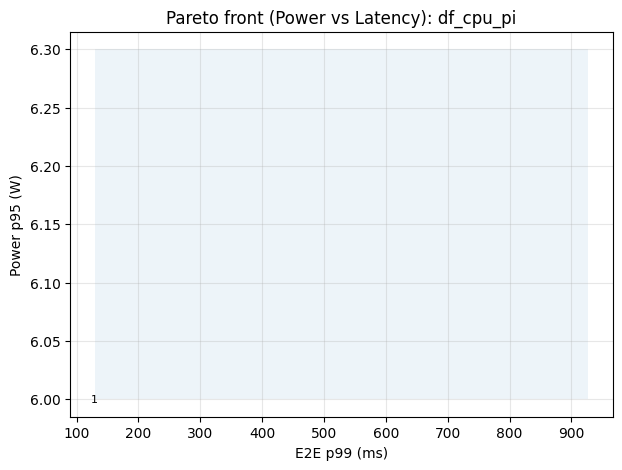

,Pareto_id_power,Label
0,1,n 256 fp32 ORT ALL


df_cpu_pi - objectif 1 (power p95 asc, p99 asc)


,Hardware,Model_Name,Latency_p99,Power_W_P95,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
3,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp32,129.356667,6.0,0.4589,10.07,1.0,375.43,559.293333,NaN
0,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp16,132.720000,6.0,0.4590,5.07,NaN,375.43,556.080000,NaN
4,CPU_ORT_PI4_SEQ_BASIC,yolo11n_256_fp32,138.183333,6.0,0.4589,10.07,NaN,375.43,558.956667,NaN


df_cpu_pi - objectif 2 (p99 asc, power p95 asc)


,Hardware,Model_Name,Latency_p99,Power_W_P95,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
3,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp32,129.356667,6.0,0.4589,10.07,1.0,375.43,559.293333,NaN
0,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp16,132.720000,6.0,0.4590,5.07,NaN,375.43,556.080000,NaN
4,CPU_ORT_PI4_SEQ_BASIC,yolo11n_256_fp32,138.183333,6.0,0.4589,10.07,NaN,375.43,558.956667,NaN


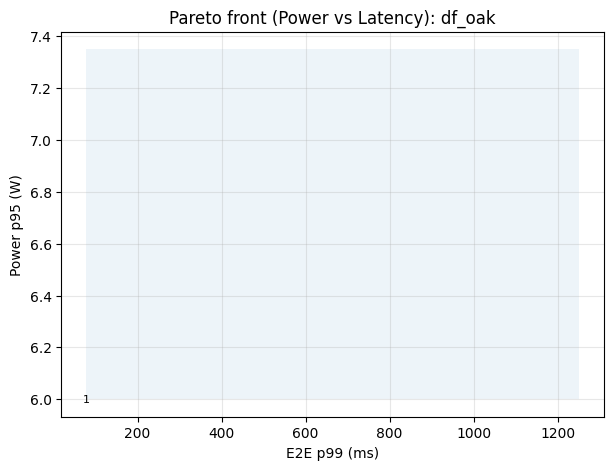

,Pareto_id_power,Label
0,1,n 256 fp16 OAK S6


df_oak - objectif 1 (power p95 asc, p99 asc)


,Hardware,Model_Name,Latency_p99,Power_W_P95,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
27,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11n_256_fp16_6shave,77.253333,6.000000,0.4567,5.54,1.0,386.276667,559.640000,NaN
26,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_5,yolo11n_256_fp16_5shave,80.423333,6.333333,0.4567,5.54,NaN,386.083333,557.516667,NaN
31,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_5,yolo11n_320_fp16_5shave,121.976667,6.333333,0.5161,5.56,NaN,387.946667,560.503333,NaN


df_oak - objectif 2 (p99 asc, power p95 asc)


,Hardware,Model_Name,Latency_p99,Power_W_P95,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
27,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11n_256_fp16_6shave,77.253333,6.000000,0.4567,5.54,1.0,386.276667,559.640000,NaN
28,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11n_256_fp16_7shave,77.473333,6.666667,0.4567,5.54,NaN,386.076667,561.406667,NaN
29,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_8,yolo11n_256_fp16_8shave,78.023333,6.666667,0.4567,5.54,NaN,386.366667,560.726667,NaN


In [14]:
# Pareto: Latency p99 (min) vs Power p95 (min)
import numpy as np
import matplotlib.pyplot as plt

def pareto_min_min(df: pd.DataFrame, x_col: str, y_col: str) -> pd.DataFrame:
    work = df.copy()
    work = work[(work["Phase"] == "run") & work[x_col].notna() & work[y_col].notna()]
    if work.empty:
        return work

    vals = work[[x_col, y_col]].values
    is_pareto = np.ones(len(work), dtype=bool)

    for i, (x, y) in enumerate(vals):
        if not is_pareto[i]:
            continue
        dominated = (vals[:, 0] <= x) & (vals[:, 1] <= y) & (
            (vals[:, 0] < x) | (vals[:, 1] < y)
        )
        if dominated.any():
            is_pareto[i] = False

    return work[is_pareto].sort_values([x_col, y_col], ascending=[True, True])


all_dfs_power = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p99", "Power_W_P95"}.issubset(val.columns)
}

pareto_power_dfs = {
    name: pareto_min_min(val, "Latency_p99", "Power_W_P95")
    for name, val in all_dfs_power.items()
}

for name, pdf in pareto_power_dfs.items():
    if pdf.empty:
        print(f"{name}: no rows")
        continue

    pdf = pdf.reset_index(drop=True)
    pdf["Pareto_id_power"] = np.arange(1, len(pdf) + 1)
    pdf["Label"] = pdf.apply(short_label, axis=1)

    # Reference point for hypervolume shading (worse corner)
    work = all_dfs_power[name]
    work = work[(work["Phase"] == "run") & work["Latency_p99"].notna() & work["Power_W_P95"].notna()]
    ref_x = work["Latency_p99"].max() * 1.05
    ref_y = work["Power_W_P95"].max() * 1.05

    fig, ax = plt.subplots(figsize=(7, 5))

    # Hypervolume (dominated region) shading
    for _, row in pdf.iterrows():
        ax.fill_between(
            [row["Latency_p99"], ref_x],
            row["Power_W_P95"],
            ref_y,
            color="tab:blue",
            alpha=0.08,
            linewidth=0,
        )

    # Points + numeric labels
    for _, row in pdf.iterrows():
        ax.text(
            row["Latency_p99"],
            row["Power_W_P95"],
            str(int(row["Pareto_id_power"])),
            fontsize=8,
            ha="center",
            va="center",
        )

    ax.set_xlabel("E2E p99 (ms)")
    ax.set_ylabel("Power p95 (W)")
    ax.set_title(f"Pareto front (Power vs Latency): {name}")
    ax.grid(True, alpha=0.3)
    plt.show()

    # Mapping table
    display(pdf[["Pareto_id_power", "Label"]])

    # Objective tables
    run = work.copy()
    pareto_map = pdf[["Hardware", "Model_Name", "Latency_p99", "Power_W_P95", "Pareto_id_power"]]
    run = run.merge(
        pareto_map,
        on=["Hardware", "Model_Name", "Latency_p99", "Power_W_P95"],
        how="left",
    )

    cols = [
        "Hardware",
        "Model_Name",
        "Latency_p99",
        "Power_W_P95",
        "mAP50",
        "Size_MB",
        "Pareto_id_power",
        "RAM_RSS_MB_Mean",
        "RAM_Sys_Used_MB_Mean",
        "VRAM_Used_MB_Mean",
    ]

    obj1 = run.sort_values(["Power_W_P95", "Latency_p99"], ascending=[True, True]).head(3)
    obj2 = run.sort_values(["Latency_p99", "Power_W_P95"], ascending=[True, True]).head(3)

    print(f"{name} - objectif 1 (power p95 asc, p99 asc)")
    display(obj1[cols])
    print(f"{name} - objectif 2 (p99 asc, power p95 asc)")
    display(obj2[cols])
